In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from typing import List, Union
from collections import OrderedDict
import itertools
from qiskit.quantum_info import Statevector
import multiprocessing as mp
from math import pi
from scipy.special import logsumexp

num_qubits = 2

In [3]:
def final_circuit(circuit, data, params):
    d = len(params)
    layers = d//num_qubits
    angle_y = ((np.pi-data[0])*(np.pi-data[1]))
    angle_z = ((np.pi-data[2])*(np.pi-data[3]))
    for i in range(num_qubits):
        circuit.h(i)
    for j in range(layers-1):
        for i in range(num_qubits):
            circuit.ry(data[i], i)
            circuit.rz(data[i+2],i)
        circuit.cx(0,1)
        circuit.ry(angle_y, 0)
        circuit.rz(angle_z, 1)
        circuit.cx(0,1)
        for i in range(num_qubits):
            circuit.ry(params[i+num_qubits*j],i)
        circuit.cx(0,1)
        
    for i in range(num_qubits):
        circuit.h(i)
        circuit.ry(data[i], i)
        circuit.rz(data[i+2],i)
    circuit.cx(0,1)
    circuit.ry(angle_y, 0)
    circuit.rz(angle_z, 1)
    circuit.cx(0,1)
    for i in range(num_qubits):
        circuit.ry(params[i+num_qubits*(layers-1)],i)

In [4]:
def _parity():
    y1 = []
    y2 = []
    basis_states = [list(i) for i in itertools.product([0, 1], repeat=num_qubits)]
    for idx, k in enumerate(basis_states):
        parity = sum(int(k[i]) for i in range(len(k)))
        if parity % 2 == 0:
            y1.append(idx)
        else:
            y2.append(idx)
    return {'y1': y1, 'y2': y2}

In [5]:
def get_probabilities(params, x):
    
    def get_probs(inds, thetas, datas, results):
        for i, theta, data in zip(inds, thetas, datas):
            circuit = QuantumCircuit(2)
            circ_ = final_circuit(circuit, data, theta)
            result = sv.evolve(circuit)
            start = i * 2**num_qubits
            end = (i+1) * 2**num_qubits
            results[start:end] = result.probabilities()
    params = np.array(params)
    x = np.array(x)      
    
     # specify number of parallel processes
    num_processes = 2

        # construct index set per process
    indices = []
    start = 0
    size = len(x) // num_processes
    for i in range(num_processes-1):
        end = start + size
        indices += [list(range(start, end))]
        start = end
    indices += [list(range(end, len(x)))]

        # initialize shared array to store results (only supports 1D-array, needs reshaping later)
    results = mp.Array('d', (len(x) * 2**num_qubits))

        # construct processes to be run in parallel
    processes = [mp.Process(target=get_probs, args=(inds, params[inds], x[inds], results))
                     for inds in indices]

    for p in processes:
        p.start()
    for p in processes:
        p.join()
    probabilities = []
    num_probs = 2**num_qubits
    for i in range(len(x)):
        start = i * num_probs
        end = (i+1) * num_probs
        probabilities += [results[start:end]]

    return probabilities

In [6]:
def get_gradient(params, x):
    grads = []
    qc_plus = []
    qc_minus = []
    zeros = np.zeros(np.shape(params))
    for i in range(d):
        #print(i)
        zeros[:, i] = np.pi / 2.
        qc_plus += [get_probabilities(params+zeros, x)]
        qc_minus += [get_probabilities(params-zeros, x)]
        zeros[:, i] = 0
        grads.append((np.array(qc_plus[i]) - np.array(qc_minus[i])) * 0.5)
    grads = np.array(grads)
    #print(grads)
        # reshape the dp_thetas
    full = np.zeros((len(x), d, 2**num_qubits))
    for j in range(len(x)):
        row = np.zeros((d, 2**num_qubits))
        for i in range(d):
            tensor = grads[i]
            row[i] += tensor[j]
        full[j] += row
    return full

In [7]:
def forward(params, x):
    def get_probs(inds, thetas, datas, results):
        for i, theta, data in zip(inds, thetas, datas):
            circuit = QuantumCircuit(2)
            circ_ = final_circuit(circuit, data, theta)
            #circuit_ = circuit.assign_parameters(self._get_params_dict(theta, data))
            result = sv.evolve(circuit)
            start = i * 2**num_qubits
            end = (i+1) * 2**num_qubits
            results[start:end] = result.probabilities()
        # map input to arrays
    params = np.array(params)
    x = np.array(x)
        # specify number of parallel processes
    num_processes = 2
        # construct index set per process
    indices = []
    start = 0
    size = len(x) // num_processes
    for i in range(num_processes-1):
        end = start + size
        indices += [list(range(start, end))]
        start = end
    indices += [list(range(end, len(x)))]

        # initialize shared array to store results (only supports 1D-array, needs reshaping later)
    results = mp.Array('d', (len(x) * 2**num_qubits))

        # construct processes to be run in parallel
    processes = [mp.Process(target=get_probs, args=(inds, params[inds], x[inds], results))
                     for inds in indices]

    for p in processes:
        p.start()
    for p in processes:
        p.join()

    aggregated_results = np.zeros((len(x), outputsize))
    num_probs = 2**num_qubits
    for i in range(len(x)):
        start = i * num_probs
        end = (i+1) * num_probs
        probabilities = results[start:end]
        temp_ = []
        for y in post_processing.keys():
            index = post_processing[y]  # index for each label
            temp_.append([sum(probabilities[u] for u in index)])
        temp_ = np.reshape(temp_, (1, outputsize))
        aggregated_results[i] = temp_
    return aggregated_results

In [8]:
def get_fisher(gradients, model_output):
    gradvectors = []
    for k in range(len(gradients)):
        jacobian = []
        m_output = model_output[k]  # p_theta size: (1, outputsize)
        jacobians_ = gradients[k, :, :]  # dp_theta size: (d, 2**num_qubits)
        for idx, y in enumerate(post_processing.keys()):
            index = post_processing[y]  # index for each label
            denominator = m_output[idx]  # get correct model output sum(p_theta) for indices
            for j in range(d):
                row = jacobians_[j, :]
                    # for each row of a particular dp_theta, do sum(dp_theta)/sum(p_theta) for indices
                    # multiply by sqrt(sum(p_theta)) so that the outer product cross term is correct
                jacobian.append(np.sqrt(denominator)*(sum(row[u] for u in index) / denominator))
            # append gradient vectors for every output for all data points
        gradvectors.append(np.reshape(jacobian, (outputsize, d)))
        print(np.reshape(jacobian, (outputsize, d)))
        # full gradient vector
    gradients = np.reshape(gradvectors, (len(gradients), outputsize, d))

    fishers = np.zeros((len(gradients), d, d))
    for i in range(len(gradients)):
        grads = gradients[i]  # size = (outputsize, d)
        temp_sum = np.zeros((outputsize, d, d))
        for j in range(outputsize):
            temp_sum[j] += np.array(np.outer(grads[j], np.transpose(grads[j])))
        fishers[i] += np.sum(temp_sum, axis=0)  # sum the two matrices to get fisher estimate
    return fishers

In [9]:
d = 8
num_qubits = 2
inputsize = 4
outputsize = 2
post_processing = OrderedDict(_parity())
sv = Statevector.from_label('0' * num_qubits)

num_inputs = 100
num_thetas = 100
thetamin = -1
thetamax = 1

rep_range = np.tile(np.array([num_inputs]), num_thetas)
params_ = np.random.uniform(thetamin, thetamax, size=(num_thetas, d))
params = np.repeat(params_, repeats=rep_range, axis=0)
x_ = np.random.normal(0, 1, size=(num_inputs, inputsize))
x = np.tile(x_, (num_thetas, 1))

In [10]:
def get_fhat():
    grads = get_gradient(params, x)
    output = forward(params, x)
    fishers = get_fisher(grads, output)
    fisher_trace = np.trace(np.average(fishers, axis=0))
    fisher = np.average(np.reshape(fishers, (num_thetas, num_inputs, d, d)), axis=1)
    f_hat = d * fisher / fisher_trace
    return f_hat, fisher_trace

In [11]:
def eff_dim(f_hat, n):
        effective_dim = []
        for ns in n:
            Fhat = f_hat * ns / (2 * pi * np.log(ns))
            one_plus_F = np.eye(d) + Fhat
            det = np.linalg.slogdet(one_plus_F)[1]  # log det because of overflow
            r = det / 2  # divide by 2 because of sqrt
            effective_dim.append(2 * (logsumexp(r) - np.log(num_thetas)) / np.log(ns / (2 * pi * np.log(ns))))
        return np.array(effective_dim)/d

In [12]:
n = [1000, 2000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

###################################################################################

f, trace = get_fhat()

0
1
2
3
4
5
6
7
[[[-0.01139717 -0.05452777  0.05208102  0.01384393]
  [ 0.1603255   0.06105956 -0.03792789 -0.18345717]
  [ 0.22940952 -0.01607013 -0.22475114  0.01141176]
  ...
  [-0.27613794 -0.03760649  0.3067947   0.00694973]
  [ 0.14672787 -0.11357853 -0.14096581  0.10781647]
  [-0.01339295 -0.21757055 -0.01129794  0.24226145]]

 [[ 0.17878572 -0.07065114 -0.01957584 -0.08855874]
  [ 0.2027185  -0.07998318 -0.28003588  0.15730056]
  [ 0.05415943  0.0548343  -0.08670285 -0.02229088]
  ...
  [-0.14205367  0.24450841 -0.05917297 -0.04328177]
  [ 0.15210315 -0.00310714 -0.30754754  0.15855153]
  [-0.00384244  0.13953432 -0.00750005 -0.12819183]]

 [[ 0.06532438 -0.04123018 -0.03119073  0.00709653]
  [-0.1406638  -0.01190069 -0.13892043  0.29148491]
  [ 0.24677758 -0.05094934 -0.01890616 -0.17692208]
  ...
  [-0.11525598 -0.08337702  0.1466306   0.0520024 ]
  [-0.1105859  -0.0515956  -0.09273086  0.25491237]
  [-0.01444764 -0.18060284  0.01190845  0.18314203]]

 ...

 [[ 0.1597514   0.

  -0.66102515  0.40063188]]
[[ 0.28213142 -0.02522451  0.28900437 -0.20591419 -0.40504605  0.06533721
  -0.56661669  0.40857615]
 [-0.25288823  0.02260996 -0.25904879  0.18457099  0.36306263 -0.05856495
   0.50788632 -0.36622683]]
[[ 0.08767048 -0.09720483  0.00484471  0.09413728  0.00488285 -0.03173127
  -0.13553234  0.1801048 ]
 [-0.34817732  0.38604233 -0.01924042 -0.37385977 -0.01939189  0.12601857
   0.53825743 -0.71527392]]
[[-0.20706055  0.17737304 -0.00798068 -0.29924629 -0.07402186  0.26293061
   0.69064868 -0.10813621]
 [ 0.09425068 -0.0807374   0.00363268  0.13621217  0.03369358 -0.11968185
  -0.31437234  0.04922189]]
[[-0.21964267  0.53496738  0.26481551  0.66595981 -0.44489033  0.47534673
  -0.21099412  0.05117273]
 [ 0.09637855 -0.23474209 -0.11620026 -0.29222118  0.19521655 -0.20858073
   0.09258359 -0.02245444]]
[[-0.19834519  0.48449387  0.09794561  0.68928665  0.31955721  0.74349417
   0.53038311  0.68917453]
 [ 0.15046999 -0.36755006 -0.07430417 -0.52291137 -0.242424

  -0.12541929 -0.17630736]]
[[-0.02376432 -0.19055049 -0.13431796  0.34435552  0.22989367 -0.27854163
   0.07577739  0.40311922]
 [ 0.02342937  0.18786478  0.13242482 -0.33950201 -0.22665343  0.27461574
  -0.07470934 -0.39743746]]
[[-0.37742873  0.36969398 -0.43425107 -0.27122389 -0.39718337 -0.1185019
  -0.44100499 -0.30138585]
 [ 0.34282958 -0.33580388  0.39444297  0.2463606   0.36077329  0.10763874
   0.40057776  0.2737576 ]]
[[ 0.49711213 -0.52335382  0.57921366 -0.44345962  0.66965844 -0.2229655
   0.55454961 -0.70720739]
 [-0.41161041  0.4333386  -0.47959073  0.36718596 -0.55447929  0.18461614
  -0.45916882  0.58556994]]
[[-0.11644056 -0.05210852  0.44209789 -0.55286266 -0.4181942   0.20202799
  -0.45962334 -0.56462565]
 [ 0.0548826   0.02456061 -0.20837653  0.26058393  0.19710987 -0.09522301
   0.21663691  0.26612824]]
[[-0.31184437 -0.35670323 -0.04294385 -0.31512441 -0.26748551  0.38367119
  -0.18339707  0.32265215]
 [ 0.48304503  0.55253112  0.06651976  0.48812579  0.41433343

   0.88146775 -0.53542707]]
[[ 0.12946632  0.14285919 -0.1092079  -0.0045814   0.01457911 -0.26535005
  -0.69009034 -0.45778754]
 [-0.0922718  -0.10181702  0.07783345  0.00326521 -0.01039066  0.18911735
   0.49183355  0.32626927]]
[[ 0.42855552  0.26793694  0.42006096 -0.42105999  0.27464337  0.32096508
  -0.12449043  0.00857941]
 [-0.24201689 -0.15131123 -0.23721978  0.23778396 -0.15509853 -0.18125766
   0.07030311 -0.00484503]]
[[-0.14771544  0.22945627 -0.12064951 -0.10462092 -0.00476383  0.24746978
  -0.13638529 -0.27044456]
 [ 0.21000774 -0.32621908  0.17152799  0.14874006  0.00677276 -0.35182897
   0.19389963  0.38449232]]
[[-0.43853157 -0.10210014 -0.48184856 -0.09198767 -0.02723834 -0.02168459
  -0.39130789  0.02857894]
 [ 0.58398216  0.13596435  0.64166637  0.12249781  0.03627266  0.02887685
   0.52109549 -0.0380579 ]]
[[ 0.15227703 -0.14542274  0.43525013  0.3052219   0.2526315   0.184118
   0.20691461 -0.14908543]
 [-0.07021284  0.06705242 -0.20068783 -0.1407336  -0.1164849 

  -0.26964272 -0.06940697]]
[[ 0.31624988  0.12534825  0.20389968  0.72166308 -0.12030609  0.15398144
  -0.30720833  0.1756949 ]
 [-0.1688793  -0.06693671 -0.10888363 -0.38537234  0.06424416 -0.082227
   0.16405106 -0.09382212]]
[[ 0.37381464 -0.52837146 -0.69979907 -0.1282813   0.53752018 -0.60774735
  -0.43550288 -0.10250091]
 [-0.1640354   0.23185722  0.30708219  0.05629173 -0.23587181  0.26668854
   0.19110511  0.04497892]]
[[-0.17905936 -0.20471327  0.06403285 -0.08690349  0.02884698 -0.00082732
  -0.47266073 -0.20616056]
 [ 0.29250906  0.33441696 -0.10460323  0.14196442 -0.04712405  0.0013515
   0.77213246  0.33678122]]
[[-0.69776817  0.39330391  0.11076005  0.69568967 -0.17356157 -0.06393752
   0.35088585  0.42589331]
 [ 0.22499089 -0.12681833 -0.03571387 -0.22432069  0.05596382  0.02061625
  -0.1131409  -0.13732658]]
[[-0.39404833 -0.29659554  0.20462756 -0.01530553 -0.09995654  0.0986963
   0.64583617  0.0330403 ]
 [ 0.40248853  0.30294838 -0.20901052  0.01563336  0.10209753 -

  -0.12010536 -0.18003338]]
[[-0.17171397  0.11945818 -0.22356672 -0.07972217 -0.03107448 -0.0359883
   0.07296909 -0.11275908]
 [ 0.30500032 -0.21218299  0.39710178  0.14160344  0.05519485  0.06392283
  -0.12960854  0.20028397]]
[[-0.22882638 -0.05604857 -0.08481186  0.16901409 -0.06115466  0.09088618
  -0.47154327  0.12584666]
 [ 0.25977267  0.06362854  0.09628174 -0.19187142  0.06942516 -0.10317755
   0.53531439 -0.14286606]]
[[ 0.51651826 -0.01287082  0.3147213  -0.09126603 -0.00385093 -0.13842998
   0.60351456 -0.17451231]
 [-0.43999324  0.01096394 -0.2680936   0.07774447  0.0032804   0.11792082
  -0.51410055  0.14865735]]
[[ 0.17975991 -0.45049119  0.27893619  0.27568869  0.42922851 -0.25589902
  -0.3078417  -0.46720102]
 [-0.11852204  0.29702472 -0.18391246 -0.18177127 -0.28300548  0.16872324
   0.20297088  0.3080421 ]]
[[-0.34709668 -0.17450353  0.18394542  0.47167323 -0.00563498  0.22315437
   0.14114171 -0.54268873]
 [ 0.33084201  0.16633146 -0.17533119 -0.44958459  0.0053710

[[ 0.35812206 -0.19045368 -0.09265568  0.78524762  0.0782441  -0.1439064
   0.2221883   0.59043337]
 [-0.25138274  0.13368841  0.06503938 -0.55120229 -0.05492322  0.10101468
  -0.15596443 -0.41445299]]
[[ 0.11773318  0.00930672  0.14030316 -0.13462458 -0.17668614 -0.24801283
   0.30621624 -0.17954118]
 [-0.20171477 -0.01594539 -0.2403844   0.23065517  0.30272014  0.42492568
  -0.52464683  0.30761173]]
[[-0.57202889  0.11360309 -0.34563865  0.28148879 -0.48714373 -0.23814117
  -0.10527098  0.30746141]
 [ 0.66338199 -0.13174551  0.4008372  -0.32644259  0.56494065  0.27617235
   0.12208277 -0.35656304]]
[[-0.15914862 -0.35211739 -0.0871364  -0.34007169  0.40379047 -0.05131513
  -0.2201768  -0.12987745]
 [ 0.11447098  0.25326782  0.06267469  0.24460371 -0.29043477  0.03690949
   0.15836679  0.09341708]]
[[ 0.08368261  0.07673605 -0.00668845 -0.09204885 -0.26127011  0.36291473
   0.20386525 -0.16362285]
 [-0.07984423 -0.0732163   0.00638166  0.08782673  0.24928611 -0.34626847
  -0.19451431 

  -0.04743016  0.75646679]]
[[-0.31007269  0.55818544  0.0261385  -0.42713004  0.15208003  0.22756239
   0.01187253 -0.15424222]
 [ 0.31022248 -0.55845509 -0.02615113  0.42733638 -0.1521535  -0.22767232
  -0.01187827  0.15431674]]
[[-0.15192424 -0.23232143 -0.3234986  -0.01258776 -0.02754818 -0.37860809
  -0.27667691  0.37508514]
 [ 0.12358528  0.1889857   0.26315527  0.01023972  0.02240952  0.307985
   0.2250674  -0.30511919]]
[[ 0.2801855   0.19899683  0.02319898 -0.20879713  0.32880292  0.2647537
  -0.00809369  0.30077013]
 [-0.39707418 -0.28201497 -0.0328772   0.29590378 -0.46597398 -0.37520449
   0.01147025 -0.42624638]]
[[ 0.31587927 -0.12131533 -0.12047017 -0.80453922  0.40009234  0.4622841
  -0.27204357  0.64223555]
 [-0.10639757  0.04086262  0.04057795  0.27099282 -0.13476304 -0.15571108
   0.09163239 -0.2163241 ]]
[[ 1.67870243e-01  3.19257919e-01 -1.07621530e-01  1.29975474e-01
  -2.72670087e-01 -8.18488182e-02  5.58162623e-04  2.65746504e-01]
 [-4.33294309e-01 -8.24045028e-

  -0.12512391 -0.687531  ]]
[[ 0.0445958  -0.05014863 -0.15194641  0.2441555  -0.28842434  0.27459507
  -0.45942979  0.19363718]
 [-0.07270728  0.08176042  0.24772763 -0.3980618   0.47023602 -0.44768932
   0.74903677 -0.31569866]]
[[ 0.0725368   0.30336568  0.0652827  -0.00715058  0.30645298 -0.54044361
   0.19494602  0.08425048]
 [-0.09221763 -0.38567547 -0.08299533  0.00909069 -0.38960042  0.68707785
  -0.24783916 -0.10710949]]
[[-0.05738465  0.49044847 -0.641855    0.41530074  0.10134047  0.05280716
  -0.11500318 -0.63838268]
 [ 0.01911197 -0.16334398  0.21376996 -0.13831601 -0.03375147 -0.01758744
   0.03830184  0.2126135 ]]
[[-0.21921373 -0.14915416 -0.16529753  0.11089005 -0.16138018 -0.2950694
  -0.02060744  0.09605313]
 [ 0.32646526  0.22212866  0.24617027 -0.16514361  0.24033633  0.43943374
   0.03068975 -0.14304765]]
[[-0.16994326 -0.2160295  -0.17500619  0.07654071  0.17204447  0.27266995
  -0.36442447  0.17935172]
 [ 0.17733397  0.22542447  0.18261708 -0.07986941 -0.1795265

   0.23704669 -0.12838257]]
[[-0.26040541 -0.14945628 -0.30692864 -0.16172427 -0.19192917  0.23477052
   0.5914197   0.20650224]
 [ 0.19392436  0.11130035  0.22857029  0.12043634  0.14292998 -0.17483401
  -0.44043128 -0.15378258]]
[[-0.06655544  0.03737606  0.37514635  0.19267516  0.03288258  0.15483778
   0.37330452  0.28759103]
 [ 0.07465104 -0.04192237 -0.42077802 -0.21611158 -0.03688232 -0.17367178
  -0.41871216 -0.32257273]]
[[ 0.28359203  0.04639579 -0.1076754   0.22165708  0.0720205   0.2004424
  -0.50078341  0.36053035]
 [-0.38519511 -0.0630181   0.14625248 -0.30107061 -0.09782343 -0.27225529
   0.68020008 -0.48969827]]
[[-0.01071082 -0.19647989  0.09836852  0.1752836   0.10743256 -0.11349934
   0.21888799 -0.44227202]
 [ 0.01768803  0.32447012 -0.16244739 -0.28946622 -0.17741589  0.18743467
  -0.36147522  0.73037527]]
[[ 0.15235665 -0.32409865  0.4690439   0.57750378 -0.3366654  -0.26326895
   0.45153474  0.10636235]
 [-0.11881813  0.25275427 -0.36579249 -0.45037692  0.2625546

  -0.39722843 -0.49066948]]
[[-0.04789052 -0.12162191 -0.05725502 -0.14143429  0.0692023   0.19439662
  -0.13312739  0.1950778 ]
 [ 0.13693844  0.34776643  0.16371534  0.40441808 -0.19787748 -0.55585889
   0.38066528 -0.55780667]]
[[ 0.24346307 -0.60209915  0.06233293  0.4461617   0.36068617 -0.11290417
  -0.22954615  0.37474829]
 [-0.17243564  0.42644393 -0.04414804 -0.31599936 -0.2554603   0.07996573
   0.16257881 -0.26541996]]
[[ 0.20212895  0.25739063 -0.07870641 -0.28594358 -0.3665551   0.10081031
  -0.09590697  0.64740551]
 [-0.14481046 -0.18440137  0.05638733  0.20485746  0.26260965 -0.07222314
   0.06871026 -0.46381822]]
[[-0.25794044  0.04837549  0.35229763 -0.52699281  0.2332698  -0.03958466
   0.25627722 -0.71591232]
 [ 0.17802333 -0.03338742 -0.24314605  0.36371581 -0.16099634  0.02732024
  -0.17687542  0.49410281]]
[[-0.29152379  0.0952912  -0.44315378 -0.02258508  0.03133898 -0.01072376
   0.05856637  0.31476503]
 [ 0.15549345 -0.05082658  0.23637011  0.01204647 -0.016715

   0.62479609  0.60923789]]
[[-0.34312732 -0.24638215 -0.48299226  0.32395133 -0.06812166  0.26814794
   0.03282934  0.81263208]
 [ 0.22743602  0.16331015  0.32014308 -0.21472554  0.04515327 -0.17773723
  -0.02176036 -0.53863913]]
[[-0.06641101 -0.07054343  0.07083807  0.60214526 -0.16591485  0.25090735
  -0.18676453 -0.40824566]
 [ 0.0351564   0.037344   -0.03749998 -0.31876131  0.08783136 -0.13282435
   0.09886868  0.2161155 ]]
[[ 0.74797701 -0.57513056  0.74145455 -0.71969608  0.58581603 -0.22111282
   0.78608233 -0.58702093]
 [-0.31255989  0.24033191 -0.30983433  0.30074204 -0.24479709  0.09239723
  -0.3284831   0.24530058]]
[[ 0.08477475  0.34875531  0.17927328 -0.23613777 -0.22419054  0.01666989
  -0.22710625  0.11846009]
 [-0.10652632 -0.43823921 -0.22527136  0.29672617  0.28171352 -0.02094707
   0.28537735 -0.14885467]]
[[ 0.17247868  0.05170043 -0.03122312  0.05115992 -0.10375369 -0.41856684
   0.18681902 -0.45211747]
 [-0.32360559 -0.09700066  0.05858101 -0.09598656  0.194663

[[-0.09120053 -0.23167159 -0.00975931  0.09191382 -0.10243188 -0.1392569
  -0.30069443 -0.00536376]
 [ 0.22756924  0.57808137  0.02435203 -0.22934909  0.25559439  0.34748248
   0.75031144  0.01338398]]
[[ 0.56374008 -0.25911922  0.35010575  0.03870845  0.15121929  0.01136025
   0.25471067  0.28284147]
 [-0.57550169  0.26452536 -0.3574102  -0.03951605 -0.15437426 -0.01159726
  -0.26002484 -0.28874254]]
[[ 0.31449328 -0.17663303  0.47202989 -0.60949611  0.00809893 -0.16786618
   0.14270975 -0.20850579]
 [-0.22221275  0.12480429 -0.33352401  0.43065405 -0.0057225   0.11860986
  -0.10083499  0.14732475]]
[[-0.08783635  0.10040498  0.35193739 -0.2477217  -0.16073143 -0.09584655
   0.19193931  0.02668918]
 [ 0.18679514 -0.21352392 -0.74843949  0.52681161  0.34181577  0.20382985
  -0.4081833  -0.05675792]]
[[-0.08813948 -0.18139991 -0.09192388 -0.32239172 -0.07345862  0.05317096
   0.35446355 -0.26360903]
 [ 0.1071872   0.22060202  0.11178943  0.3920634   0.08933367 -0.06466167
  -0.43106623 

   0.19913573  0.17044924]]
[[ 0.47920401  0.10060132  0.43304438 -0.24753928  0.21519394  0.24148249
   0.56842241 -0.77690004]
 [-0.19939338 -0.04185949 -0.18018669  0.10299933 -0.08954067 -0.10047915
  -0.23651652  0.32326258]]
[[-0.11284458 -0.1780753   0.23832694 -0.13586644  0.07445163 -0.0854343
  -0.04058663 -0.25538665]
 [ 0.29806563  0.47036489 -0.6295125   0.35887518 -0.1966552   0.22566461
   0.10720479  0.67457369]]
[[ 0.57075628 -0.31418716 -0.17434948 -0.09251637 -0.09999842 -0.14188506
   0.46166666 -0.37430483]
 [-0.28005098  0.15416111  0.08554745  0.04539469  0.04906588  0.06961824
  -0.22652436  0.18365884]]
[[-0.52718091  0.49818617 -0.45847439  0.22990714 -0.05877758 -0.21255765
   0.07352213 -0.44147476]
 [ 0.46659822 -0.44093551  0.40578733 -0.20348662  0.05202296  0.18813091
  -0.0650731   0.39074127]]
[[-0.40832201 -0.38464943 -0.70692117 -0.05080183  0.00580911 -0.28429991
   0.74558309  0.31558196]
 [ 0.21468773  0.20224115  0.37168533  0.02671061 -0.0030543

[[ 0.03716578  0.2524722   0.07442511  0.74100818 -0.34128049  0.52753728
  -0.2025058  -0.223834  ]
 [-0.0254033  -0.17256804 -0.05087054 -0.50648876  0.23326967 -0.36057862
   0.13841536  0.15299346]]
[[-0.02619312  0.24774161 -0.35674785  0.1025571  -0.3646482   0.44492077
  -0.14496985  0.38865689]
 [ 0.03250355 -0.30742735  0.44269531 -0.12726509  0.452499   -0.55211078
   0.17989589 -0.48229184]]
[[ 0.09875455  0.0022857  -0.18856635  0.01776069 -0.12126515 -0.16710346
  -0.08761094 -0.01679945]
 [-0.24001606 -0.00555523  0.45829741 -0.04316611  0.29472652  0.40613335
   0.2129323   0.0408299 ]]
[[ 0.27408866  0.0080246   0.24673732  0.13187638  0.03914696  0.24689339
   0.35529123  0.22410058]
 [-0.19491088 -0.00570648 -0.1754607  -0.09378039 -0.02783832 -0.17557169
  -0.25265593 -0.15936319]]
[[ 0.14224158  0.23798896 -0.05959418 -0.21358914  0.08133994 -0.05142386
   0.08625329  0.22135171]
 [-0.1704157  -0.28512799  0.07139814  0.25589523 -0.09745113  0.0616095
  -0.10333767 

   0.09555844  0.1371081 ]]
[[ 2.15487540e-01 -4.83663313e-04  2.99533320e-01 -2.17127110e-01
   1.36237156e-01  2.69442301e-02 -1.20710141e-01  6.22887185e-01]
 [-2.23391617e-01  5.01404071e-04 -3.10520195e-01  2.25091327e-01
  -1.41234331e-01 -2.79325437e-02  1.25137785e-01 -6.45734670e-01]]
[[-0.10256776 -0.05018274  0.3008598  -0.17395049  0.15305343  0.22065076
   0.50784653  0.32154831]
 [ 0.14411959  0.07051256 -0.42274287  0.24442059 -0.2150578  -0.31003988
  -0.71358321 -0.45181263]]
[[-0.12121106  0.09209863  0.18293167  0.47250002  0.29897191 -0.19412843
  -0.34555743  0.25327067]
 [ 0.0877715  -0.06669057 -0.1324647  -0.34214728 -0.21649189  0.14057251
   0.25022546 -0.18339866]]
[[-0.01881158  0.168529   -0.22912881  0.10921563 -0.15045158  0.14055831
  -0.04001777  0.02483318]
 [ 0.04093889 -0.36676292  0.49864385 -0.2376816   0.32742176 -0.30589142
   0.08708907 -0.05404346]]
[[ 0.01138117  0.66209538  0.11413255  0.45234468  0.01220912 -0.43967313
   0.19320641 -0.58527

   0.1655469  -0.30105069]]
[[ 0.0271724  -0.21586819  0.06375317  0.17913875 -0.02063117 -0.34611341
  -0.33204033  0.388698  ]
 [-0.04204552  0.33402607 -0.09864919 -0.27719236  0.03192387  0.53556248
   0.51378634 -0.60145622]]
[[ 0.00731605 -0.28850525 -0.46673861  0.12188052  0.42689987 -0.11487849
   0.2729189  -0.60230935]
 [-0.00304974  0.12026502  0.19456259 -0.05080657 -0.17795559  0.04788774
  -0.11376776  0.251076  ]]
[[ 0.28556121  0.26640461 -0.19116825  0.19183334 -0.08586859  0.42514539
   0.3944087  -0.05893424]
 [-0.07119575 -0.06641965  0.04766182 -0.04782764  0.02140864 -0.10599669
  -0.09833346  0.01469341]]
[[ 0.09077693  0.08968253  0.23325558 -0.12639207 -0.07497082 -0.13907146
   0.38179532 -0.38784949]
 [-0.1513352  -0.14951071 -0.38886289  0.21070958  0.12498467  0.23184753
  -0.6364951   0.64658807]]
[[ 0.38322804 -0.12653    -0.05173957 -0.30566334  0.3846532  -0.21963444
   0.02269546 -0.60924951]
 [-0.42417211  0.14004847  0.05726743  0.3383204  -0.425749

[[ 0.14256713  0.06848642 -0.15264913 -0.31099932  0.33112835  0.06466394
  -0.40602113 -0.2996707 ]
 [-0.15388151 -0.07392163  0.16476364  0.33568078 -0.35740728 -0.06979578
   0.43824368  0.3234531 ]]
[[-0.61361905 -0.63814993 -0.23682202 -0.10577135 -0.34903559 -0.28308144
  -0.32808704 -0.54737625]
 [ 0.58295496  0.60625997  0.22498743  0.10048569  0.33159341  0.26893515
   0.31169171  0.52002249]]
[[-0.44932314  0.16025359 -0.39481304 -0.15878118  0.12834827  0.07449241
  -0.15045471 -0.42124513]
 [ 0.5167948  -0.18431773  0.4540993   0.18262422 -0.14762141 -0.0856784
   0.17304743  0.48450051]]
[[-0.07174719  0.28895888  0.01357045 -0.14572175 -0.30479274  0.08599038
   0.15877145 -0.04250088]
 [ 0.14865907 -0.59871835 -0.02811776  0.30193323  0.63152587 -0.17817075
  -0.328972    0.08806116]]
[[-0.07128287  0.01511774  0.39528957  0.10637234 -0.14518958  0.29607221
   0.57016676  0.15104155]
 [ 0.07366051 -0.015622   -0.40847444 -0.10992038  0.15003237 -0.30594768
  -0.58918464 

  -3.33450058e-01  5.36410013e-02  2.38825070e-04  1.67745647e-02]]
[[-0.37243557  0.36296075 -0.45071141  0.03472061 -0.26192642  0.05364045
   0.08017041  0.09043215]
 [ 0.66497077 -0.64805382  0.80472957 -0.06199245  0.46766051 -0.09577316
  -0.14314149 -0.16146347]]
[[-0.57508546 -0.03600071 -0.56865677  0.04654785  0.10581644 -0.11390733
   0.68648104  0.6613313 ]
 [ 0.27690682  0.01733454  0.27381137 -0.02241305 -0.0509512   0.05484701
  -0.33054441 -0.31843467]]
[[-0.03204532 -0.45072074  0.14215943  0.26742198  0.47636126  0.07172823
   0.52356417 -0.39835324]
 [ 0.01031717  0.14511203 -0.04576901 -0.08609798 -0.15336714 -0.0230933
  -0.16856438  0.12825202]]
[[-0.0025576   0.19623663  0.03058143 -0.04574142 -0.37751449 -0.03571835
  -0.11322737  0.22151236]
 [ 0.00284764 -0.21848982 -0.03404935  0.05092849  0.42032455  0.0397688
   0.12606733 -0.24663181]]
[[ 0.17107552 -0.25853157 -0.05544004  0.13864345 -0.05148725  0.09247287
  -0.51919427  0.61862585]
 [-0.1387575   0.2096

[[ 0.05337602 -0.32748829  0.26387106 -0.42610695  0.04052914 -0.25642937
  -0.09786388  0.28067455]
 [-0.06991791  0.42898094 -0.34564794  0.55816274 -0.05308963  0.33589999
   0.1281931  -0.36765905]]
[[ 0.20453472  0.29818655  0.22542797 -0.19054154 -0.27420116 -0.07473433
   0.11594422  0.16638334]
 [-0.37718117 -0.54988391 -0.41571027  0.35137642  0.50565261  0.13781709
  -0.213812   -0.30682644]]
[[-0.08492726 -0.12880777  0.2416172   0.18338223  0.08056542 -0.36284238
   0.10529496 -0.20464733]
 [ 0.05506283  0.08351288 -0.15665319 -0.11889638 -0.05223481  0.23524987
  -0.06826828  0.13268367]]
[[ 0.0083151   0.03200131  0.13823613 -0.14833002  0.01008601 -0.3705667
  -0.48346287  0.19625222]
 [-0.00881044 -0.03390767 -0.14647101  0.15716621 -0.01068684  0.39264179
   0.51226332 -0.2079432 ]]
[[ 0.03234277  0.09854836  0.19041583  0.08705469  0.01610155  0.03189698
   0.06483505  0.15728209]
 [-0.1249227  -0.38063924 -0.73547381 -0.33624538 -0.06219162 -0.12320086
  -0.25042287 

[[-0.03762119 -0.02051696 -0.14256474  0.11026988 -0.08316268 -0.1283836
  -0.47541626  0.14901244]
 [ 0.04129837  0.02252233  0.15649934 -0.12104791  0.09129119  0.1409321
   0.52188453 -0.16357726]]
[[-0.22729822  0.25457201 -0.01401423 -0.50615892  0.10623437  0.17567452
   0.40841301  0.36447722]
 [ 0.21922644 -0.24553169  0.01351656  0.48818428 -0.10246179 -0.16943599
  -0.39390951 -0.35153396]]
[[-0.10492623 -0.11694633  0.0193936  -0.14084403  0.37616647  0.07409117
  -0.17257895 -0.11963671]
 [ 0.11869864  0.13229648 -0.02193916  0.15933094 -0.42554133 -0.08381623
   0.19523132  0.13533999]]
[[ 0.4710434  -0.38842459  0.21853835 -0.20632167  0.17596994 -0.09735319
   0.27981885 -0.31479709]
 [-0.15785398  0.13016713 -0.0732356   0.0691416  -0.05897027  0.03262457
  -0.09377165  0.10549341]]
[[ 0.50474767  0.47333676 -0.08945024 -0.03719202 -0.18472082 -0.44702698
   0.40019502  0.48358852]
 [-0.3725288  -0.349346    0.06601871  0.02744955  0.13633312  0.32992807
  -0.29536377 -

  -0.30506775 -0.18574836]]
[[-0.21335299 -0.06180018 -0.01431108  0.02363114 -0.10804598 -0.04332947
   0.1655746   0.32546224]
 [ 0.3769405   0.10918521  0.02528403 -0.04175022  0.19088978  0.07655215
  -0.29252822 -0.57500904]]
[[-0.01481701  0.53960432  0.1477401  -0.29847869  0.05881878  0.00312714
   0.56134067  0.20795292]
 [ 0.01536951 -0.55972503 -0.15324902  0.30960833 -0.061012   -0.00324375
  -0.58227189 -0.21570705]]
[[-0.40560894  0.10799504 -0.23992024  0.13193447 -0.41363474 -0.42230309
  -0.2304078  -0.12974345]
 [ 0.38952938 -0.10371379  0.23040907 -0.12670419  0.39723701  0.40556172
   0.22127374  0.12460003]]
[[-0.23905673  0.00046409 -0.27256039  0.06526124  0.3029082  -0.11268156
  -0.15754828 -0.05082467]
 [ 0.15805976 -0.00030685  0.18021174 -0.04314949 -0.20027714  0.07450291
   0.10416792  0.03360431]]
[[-0.33755584  0.50093222  0.08898168  0.10145326  0.27889484  0.06630164
   0.23813624 -0.2994435 ]
 [ 0.1975211  -0.29312093 -0.05206771 -0.05936546 -0.163195

   0.27173746 -0.24627741]]
[[ 0.00419241 -0.12926283  0.05024544  0.43721266  0.06065552  0.28890924
  -0.28621198  0.20390656]
 [-0.00463391  0.14287538 -0.05553674 -0.48325511 -0.0670431  -0.31933399
   0.31635269 -0.22537977]]
[[ 0.04502023 -0.30185328 -0.44366383  0.1066059   0.44873879 -0.27627532
  -0.73809815  0.14657287]
 [-0.03992039  0.26765966  0.39340606 -0.0945297  -0.39790612  0.24497914
   0.65448716 -0.12996925]]
[[-0.29003908 -0.28155603 -0.05047651  0.18643265 -0.08457466 -0.01821685
  -0.39690769  0.13854132]
 [ 0.58116053  0.56416276  0.10114138 -0.37356103  0.16946493  0.03650169
   0.79529656 -0.27759966]]
[[-0.11143757 -0.23447142  0.57346583  0.62789297  0.22051757 -0.06530972
   0.70873091  0.3505958 ]
 [ 0.05929143  0.12475277 -0.305118   -0.33407648 -0.11732849  0.03474866
  -0.37708708 -0.18653786]]
[[ 0.16119084  0.17067002 -0.18106745 -0.32957502 -0.35899521  0.31884453
   0.21848839 -0.16353435]
 [-0.19233148 -0.20364195  0.21604807  0.39324598  0.428349

  -0.12904611 -0.03801252]]
[[-0.35090888  0.15870745 -0.16935455 -0.13437805  0.38060027 -0.31274862
   0.20611917  0.33036455]
 [ 0.26991675 -0.1220767   0.13026638  0.10336269 -0.29275516  0.24056413
  -0.15854548 -0.25411419]]
[[-0.0462511   0.37397385  0.0396346   0.28114019  0.10559378  0.28405788
  -0.01871366  0.23601936]
 [ 0.09118944 -0.73733311 -0.07814423 -0.55430069 -0.20819045 -0.56005327
   0.03689617 -0.46533972]]
[[ 0.52806507 -0.09953658  0.53660411 -0.23012812  0.48110958 -0.36172411
   0.24668963 -0.25088033]
 [-0.43217916  0.08146276 -0.43916768  0.18834152 -0.39374983  0.29604235
  -0.20189579  0.20532554]]
[[ 0.43543219  0.52894446 -0.32356443  0.20370835 -0.43481751 -0.04329767
   0.61892828 -0.1398245 ]
 [-0.31705311 -0.3851426   0.23559836 -0.14832704  0.31660554  0.03152652
  -0.45066291  0.10181101]]
[[-0.21131508 -0.23905957  0.06594814 -0.37314117  0.13114414 -0.07174898
   0.02665691 -0.41123827]
 [ 0.20065161  0.22699606 -0.06262024  0.35431158 -0.124526

In [13]:
effdim = eff_dim(f, n)

In [14]:
effdim

array([0.98542271, 0.98173259, 0.98221777, 0.98260823, 0.98522212,
       0.98593451, 0.98676836, 0.98737828, 0.98778386, 0.98893719,
       0.98968619])

In [15]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Effective Dimension - 4 Layers, Hard Model (Classical Fisher Information Matrix)')

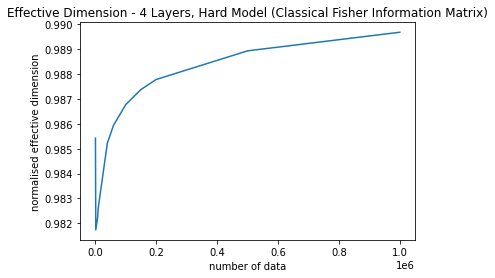

In [16]:
plt.plot(n, effdim)
plt.ylabel("normalised effective dimension")
plt.xlabel("number of data")
plt.title("Effective Dimension - 4 Layers, Hard Model (Classical Fisher Information Matrix)")

In [17]:
np.save("Data/2qubits_4layerhard_f_hats_pauli.npy", f)
np.save("Data/2qubits_4layerhard_effective_dimension_pauli.npy", effdim)

In [18]:
eff_dimeasy = np.load("Data/2qubits_4layer_effective_dimension_pauli.npy", allow_pickle=True)

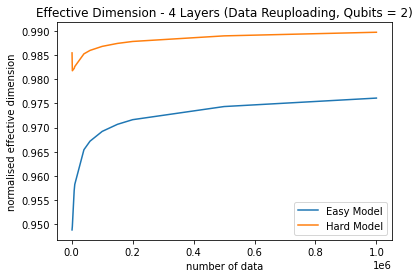

In [19]:
plt.plot(n, eff_dimeasy)
plt.plot(n, effdim)

plt.xlabel("number of data")
plt.ylabel("normalised effective dimension")
plt.title("Effective Dimension - 4 Layers (Data Reuploading, Qubits = 2)")

legendList = ['{}'.format(i) for i in ["Easy Model", "Hard Model"]]
plt.legend(legendList)